# Tech Challenge - Análise de Atrasos de Voos

**O problema** </br>
O transporte aéreo é uma parte vital da infraestrutura global, mas os 
atrasos de voos impactam milhões de passageiros todos os anos. Neste projeto, 
você utilizará o conjunto de dados público que contém informações detalhadas 
sobre voos nos EUA para desenvolver análises e modelos preditivos e/ou 
exploratórios aplicando técnicas de Machine Learning supervisionado e não 
supervisionado. 

**Objetivos do Projeto** </br>
Aplicar o conhecimento adquirido sobre modelagem supervisionada e não 
supervisionada e desenvolver um pipeline completo de ciência de dados, desde 
a exploração dos dados até a interpretação dos resultados. 

## Exploração dos dados

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Carregar os dados dos arquivos CSV
flights_df = pd.read_csv('flights.csv')
airlines_df = pd.read_csv('airlines.csv')
airports_df = pd.read_csv('airports.csv')

C:\Users\Carol\AppData\Local\Temp\ipykernel_9724\2754484279.py:6: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  flights_df = pd.read_csv('flights.csv')


Inicialmente, vamos observar apenas as primeiras linhas do nosso dataframe, selecionando apenas algumas colunas relevantes sobre atrasos. Com elas já conseguimos extrair algumas informações importantes.

In [23]:
# Copiando o dataframe principal e exibindo as primeiras linhas
df_convert_time_delay = flights_df.copy()[:10]

# Função para formatar horas no formato HHMM para HH:MM para melhor visualização
def format_heure(heure):
    if pd.isna(heure):
        return None
    heure_str = str(int(heure)).zfill(4)
    return f"{heure_str[:2]}:{heure_str[2:]}"

df_convert_time_delay['SCHEDULED_DEPARTURE'] = df_convert_time_delay['SCHEDULED_DEPARTURE'].apply(format_heure)
df_convert_time_delay['DEPARTURE_TIME'] = df_convert_time_delay['DEPARTURE_TIME'].apply(format_heure)
df_convert_time_delay['SCHEDULED_ARRIVAL'] = df_convert_time_delay['SCHEDULED_ARRIVAL'].apply(format_heure)
df_convert_time_delay['ARRIVAL_TIME'] = df_convert_time_delay['ARRIVAL_TIME'].apply(format_heure)

cols_relevant = ['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY']

df_convert_time_delay[cols_relevant]

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
0,00:05,23:54,-11.0,04:30,04:08,-22.0
1,00:10,00:02,-8.0,07:50,07:41,-9.0
2,00:20,00:18,-2.0,08:06,08:11,5.0
3,00:20,00:15,-5.0,08:05,07:56,-9.0
4,00:25,00:24,-1.0,03:20,02:59,-21.0
5,00:25,00:20,-5.0,06:02,06:10,8.0
6,00:25,00:19,-6.0,05:26,05:09,-17.0
7,00:30,00:44,14.0,08:03,07:53,-10.0
8,00:30,00:19,-11.0,05:45,05:32,-13.0
9,00:30,00:33,3.0,07:11,06:56,-15.0


### Explicação sobre Valores Negativos e Positivos em ARRIVAL_DELAY e DEPARTURE_DELAY

Após a análise descritiva acima, é importante esclarecer o significado dos valores nas colunas `ARRIVAL_DELAY` e `DEPARTURE_DELAY`:

- **Valores positivos** (maiores que 0): Indicam atrasos. Para `ARRIVAL_DELAY`, o voo chegou atrasado; para `DEPARTURE_DELAY`, o voo partiu atrasado.
- **Valores negativos** (menores que 0): Indicam chegadas ou partidas adiantadas. Para `ARRIVAL_DELAY`, o voo chegou antes do horário programado; para `DEPARTURE_DELAY`, o voo partiu antes do horário programado.
- **Valor zero**: Chegada ou partida exatamente no horário programado.

### Análise e tratamento de valores nulos na coluna ARRIVAL_DELAY
Antes de iniciarmos as análises, vamos analisar também valores nulos na coluna ARRIVAL_DELAY. Onde ARRIVAL_DELAY for nulo, vamos calcular ele através da diferença das colunas SCHEDULED_ARRIVAL e ARRIVAL_TIME, se presentes.

In [24]:
print(f"Quantidade de ARRIVAL_DELAY nulos: {flights_df['ARRIVAL_DELAY'].isnull().sum()}")

# Filtrar linhas onde ARRIVAL_DELAY é nulo e SCHEDULED_ARRIVAL e ARRIVAL_TIME não são nulos
df_filtered = flights_df[
    (flights_df['ARRIVAL_DELAY'].isnull()) &
    (flights_df['SCHEDULED_ARRIVAL'].notnull()) &
    (flights_df['ARRIVAL_TIME'].notnull())
].copy()

print(f"Linhas para calcular ARRIVAL_DELAY: {len(df_filtered)}")

def hhmm_to_minutes(hhmm):
    hhmm = int(hhmm)
    return (hhmm // 100) * 60 + (hhmm % 100)

df_filtered['SCHEDULED_MIN'] = df_filtered['SCHEDULED_ARRIVAL'].apply(hhmm_to_minutes)
df_filtered['ARRIVAL_MIN'] = df_filtered['ARRIVAL_TIME'].apply(hhmm_to_minutes)

# Diferença
df_filtered['ARRIVAL_DELAY'] = df_filtered['ARRIVAL_MIN'] - df_filtered['SCHEDULED_MIN']

# Ajuste para voos que cruzam a meia-noite
df_filtered.loc[
    df_filtered['ARRIVAL_DELAY'] < -720,
    'ARRIVAL_DELAY'
] += 1440

df_filtered[['FLIGHT_NUMBER', 'TAIL_NUMBER', 'ARRIVAL_DELAY', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME']].head(10)

Quantidade de ARRIVAL_DELAY nulos: 105071
Linhas para calcular ARRIVAL_DELAY: 12558


,FLIGHT_NUMBER,TAIL_NUMBER,ARRIVAL_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME
724,716,N944DL,282,1009,1451.0
1455,5237,N712SK,264,1041,1505.0
2218,1966,N685SW,139,1000,1219.0
2526,4555,N12552,182,1017,1319.0
2866,1081,N214WN,128,1135,1343.0
4225,1279,N541AA,338,1300,1838.0
4394,4506,N613SK,88,1225,1353.0
4574,6171,N17159,257,1218,1635.0
4636,4169,N11547,227,1243,1630.0
6422,399,N456UA,254,2105,119.0


In [25]:
# Aplicar os valores calculados de ARRIVAL_DELAY de df_filtered de volta ao flights_df
flights_df.update(df_filtered[['ARRIVAL_DELAY']])

# Verificar se os valores foram aplicados
verify_update_df = flights_df[(flights_df['FLIGHT_NUMBER'] == 716) & (flights_df['TAIL_NUMBER'] == 'N944DL')][['SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY']]
print(verify_update_df)

     SCHEDULED_ARRIVAL  ARRIVAL_TIME  ARRIVAL_DELAY
724               1009        1451.0          282.0


### Análise de outras colunas com valores nulos

In [26]:
print("\nPercentual de valores nulos por coluna:")
null_percent = (flights_df.isnull().mean() * 100).round(2)
print(null_percent)


Percentual de valores nulos por coluna:
YEAR                    0.00
MONTH                   0.00
DAY                     0.00
DAY_OF_WEEK             0.00
AIRLINE                 0.00
FLIGHT_NUMBER           0.00
TAIL_NUMBER             0.25
ORIGIN_AIRPORT          0.00
DESTINATION_AIRPORT     0.00
SCHEDULED_DEPARTURE     0.00
DEPARTURE_TIME          1.48
DEPARTURE_DELAY         1.48
TAXI_OUT                1.53
WHEELS_OFF              1.53
SCHEDULED_TIME          0.00
ELAPSED_TIME            1.81
AIR_TIME                1.81
DISTANCE                0.00
WHEELS_ON               1.59
TAXI_IN                 1.59
SCHEDULED_ARRIVAL       0.00
ARRIVAL_TIME            1.59
ARRIVAL_DELAY           1.59
DIVERTED                0.00
CANCELLED               0.00
CANCELLATION_REASON    98.46
AIR_SYSTEM_DELAY       81.72
SECURITY_DELAY         81.72
AIRLINE_DELAY          81.72
LATE_AIRCRAFT_DELAY    81.72
WEATHER_DELAY          81.72
dtype: float64


Com base no percentual de valores nulos por coluna, podemos identificar quais dados manter ou descartar para otimizar a análise e modelagem:

- **Colunas com baixos percentuais de nulos (0.25% a 1.81%)**: TAIL_NUMBER (0.25%), DEPARTURE_TIME (1.48%), DEPARTURE_DELAY (1.48%), TAXI_OUT (1.53%), WHEELS_OFF (1.53%), ELAPSED_TIME (1.81%), AIR_TIME (1.81%), WHEELS_ON (1.59%), TAXI_IN (1.59%), ARRIVAL_TIME (1.59%), ARRIVAL_DELAY (1.59%). Esses valores ausentes são relativamente poucos e podem ser imputados (e.g., com médias ou zeros para atrasos) ou tratados com drop de linhas, posteriormente.

- **Colunas com altos percentuais de nulos (>80%)**: CANCELLATION_REASON (98.46%), AIR_SYSTEM_DELAY (81.72%), SECURITY_DELAY (81.72%), AIRLINE_DELAY (81.72%), LATE_AIRCRAFT_DELAY (81.72%), WEATHER_DELAY (81.72%). Esses campos estão majoritariamente vazios. Como representam casos raros ou específicos, podem ser **descartados** para simplificar o dataset, evitando viés e reduzindo dimensionalidade.

Além das colunas com altos percentuais de nulos, também podemos remover outras que não impactam diretamente nos voos atrasados, sendo elas: TAIL_NUMBER, AIR_TIME, WHEELS_ON.

In [27]:
df = flights_df.copy()

# Remover colunas que não impactam na análise de atrasos
cols_to_drop = ['TAIL_NUMBER', 'AIR_TIME', 'WHEELS_OFF', 
                'WHEELS_ON', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY',
                'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']

df = df.drop(columns=cols_to_drop)

#### Porcentagem de voos com atraso na chegada
Aproximadamente 36% dos voos apresentaram atraso na chegada.

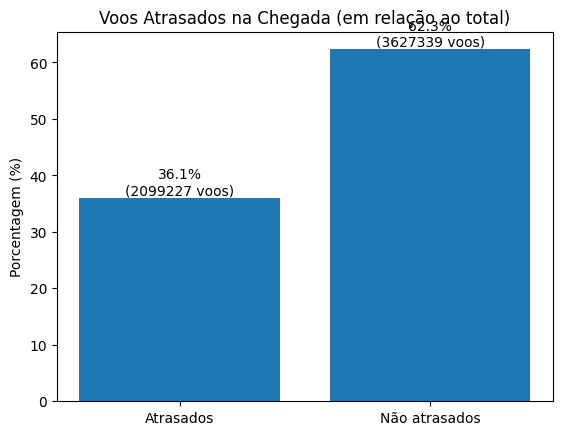

In [28]:
total_voos = len(df)

# Quantidades
qtd_atrasados = np.sum(df["ARRIVAL_DELAY"] > 0)
qtd_no_horario = np.sum(df["ARRIVAL_DELAY"] <= 0)

# Porcentagens (em relação ao total)
percent_atrasados = (qtd_atrasados / total_voos) * 100
percent_no_horario = (qtd_no_horario / total_voos) * 100

# Dados para o gráfico
labels = ["Atrasados", "Não atrasados"]
percentuais = [percent_atrasados, percent_no_horario]
quantidades = [qtd_atrasados, qtd_no_horario]

plt.figure()
bars = plt.bar(labels, percentuais)
plt.ylabel("Porcentagem (%)")
plt.title("Voos Atrasados na Chegada (em relação ao total)")

# Adicionando rótulos (porcentagem + quantidade)
for bar, qtd in zip(bars, quantidades):
    altura = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        altura,
        f"{altura:.1f}%\n({qtd} voos)",
        ha="center",
        va="bottom"
    )

plt.show()


#### Atrasos por companhia aérea

Pesquisar porte desses aeroportos e buscar correlação

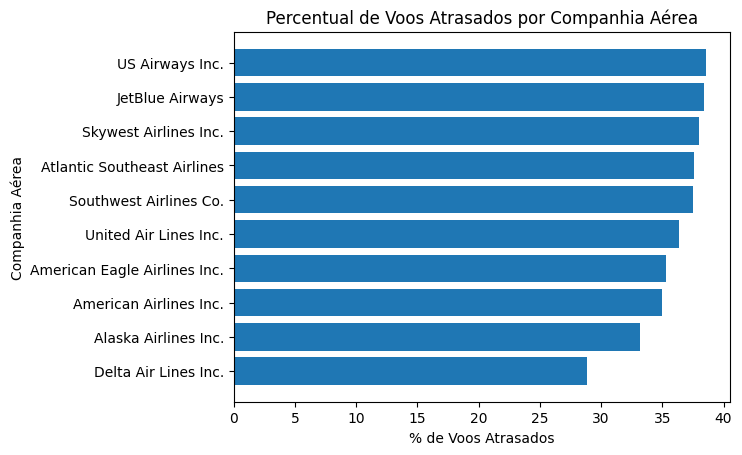

In [29]:
df_merged_airlines = df.merge(
    airlines_df,
    left_on="AIRLINE",
    right_on="IATA_CODE",
    how="left"
)

df_merged_airlines = df_merged_airlines.rename(columns={"AIRLINE_y": "AIRLINE_NAME"})

airline_delay = (
    df_merged_airlines
    .groupby("AIRLINE_NAME")
    .agg(
        total_voos=("FLIGHT_NUMBER", "count"),
        voos_atrasados=("ARRIVAL_DELAY", lambda x: np.sum(x > 0))
    )
)

airline_delay["percent_atrasados"] = (
    airline_delay["voos_atrasados"] / airline_delay["total_voos"] * 100
)

# Filtra companhias com volume relevante
airline_delay = airline_delay[airline_delay["total_voos"] > 10000]

# Ordena
airline_delay = airline_delay.sort_values("percent_atrasados").head(10)

plt.figure()
plt.barh(
    airline_delay.index,
    airline_delay["percent_atrasados"]
)

plt.xlabel("% de Voos Atrasados")
plt.ylabel("Companhia Aérea")
plt.title("Percentual de Voos Atrasados por Companhia Aérea")

plt.show()


#### Percentual de atrasos durante o ano
Observam-se picos nos meses de inverno e durante o verão, períodos que coincidem, respectivamente, com condições climáticas adversas e férias escolares nos Estados Unidos. Meses com menor demanda apresentam percentuais significativamente mais baixos de atraso, indicando impacto direto do volume de passageiros na pontualidade operacional.

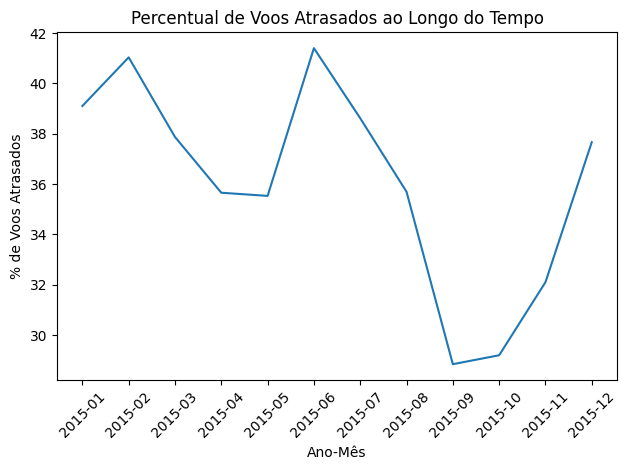

In [30]:
# Agrupamento por ano e mês
delay_time = (
    df
    .groupby(["YEAR", "MONTH"])
    .agg(
        total_voos=("FLIGHT_NUMBER", "count"),
        voos_atrasados=("ARRIVAL_DELAY", lambda x: np.sum(x > 0))
    )
    .reset_index()
)

# Percentual de atraso
delay_time["percent_atrasados"] = (
    delay_time["voos_atrasados"] / delay_time["total_voos"] * 100
)

# Criar eixo temporal contínuo (ótimo para visualização)
delay_time["ANO_MES"] = (
    delay_time["YEAR"].astype(str) + "-" +
    delay_time["MONTH"].astype(str).str.zfill(2)
)

plt.figure()
plt.plot(
    delay_time["ANO_MES"],
    delay_time["percent_atrasados"]
)

plt.xlabel("Ano-Mês")
plt.ylabel("% de Voos Atrasados")
plt.title("Percentual de Voos Atrasados ao Longo do Tempo")

# Melhorar legibilidade do eixo X
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

#### Correlação com atrasos na chegada com atrasos na saída
A elevada (0.92) correlação sugere que o atraso na partida é um forte indicador no atraso na chegada. Isso indica um efeito de cascata operacional, no qual atrasos iniciais impactam diretamente etapas subsequentes do voo.

Pontos acima da reta (y > x) indicam que o voo chegou mais atrasado do que saiu. 
Pontos abaixo da reta (y < x) indicam que o voo recuperou parte do atraso durante a operação.


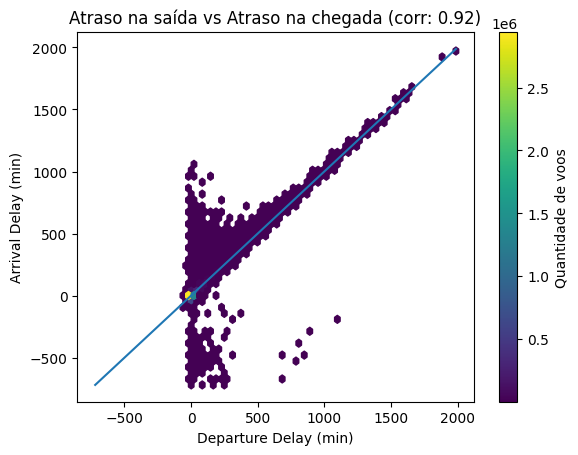

In [31]:
# Seleciona apenas as colunas necessárias e remove NaNs
df_hex = df[["DEPARTURE_DELAY", "ARRIVAL_DELAY"]].dropna()

x = df_hex["DEPARTURE_DELAY"]
y = df_hex["ARRIVAL_DELAY"]

corr = x.corr(y)

plt.figure()
hb = plt.hexbin(
    x,
    y,
    gridsize=50,      
    mincnt=1         
)

plt.xlabel("Departure Delay (min)")
plt.ylabel("Arrival Delay (min)")
plt.title(f"Atraso na saída vs Atraso na chegada (corr: {corr:.2f})")

# Linha de referência y = x (propagação do atraso)
min_val = min(x.min(), y.min())
max_val = max(x.max(), y.max())
plt.plot(
    [min_val, max_val],
    [min_val, max_val]
)

# Barra de cor (densidade)
plt.colorbar(hb, label="Quantidade de voos")

plt.show()

#### Voos Cancelados x Desviados
A análise mostra que menos de 2% dos voos foram cancelados ou desviados. Isso indica que esses eventos são raros no conjunto de dados.

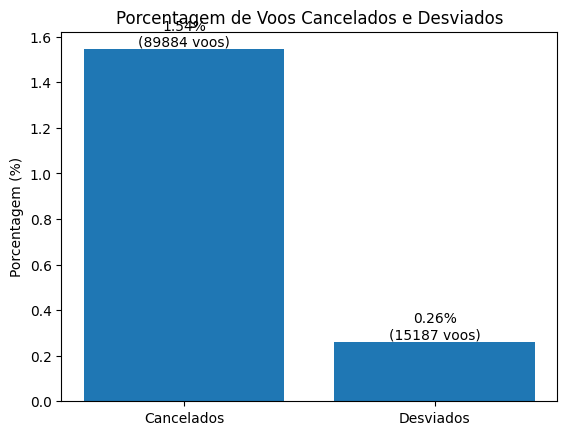

In [32]:
total_voos = len(df)

# Quantidades
qtd_cancelados = np.sum(df["CANCELLED"] == 1)
qtd_desviados = np.sum(df["DIVERTED"] == 1)

# Porcentagens em relação ao total
percent_cancelados = (qtd_cancelados / total_voos) * 100
percent_desviados = (qtd_desviados / total_voos) * 100

plt.figure()
bars = plt.bar(
    ["Cancelados", "Desviados"],
    [percent_cancelados, percent_desviados]
)

plt.ylabel("Porcentagem (%)")
plt.title("Porcentagem de Voos Cancelados e Desviados")

for bar, qtd in zip(bars, [qtd_cancelados, qtd_desviados]):
    altura = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        altura,
        f"{altura:.2f}%\n({qtd} voos)",
        ha="center",
        va="bottom"
    )

plt.show()

#### Distribuição dos Atrasos de Chegada por Mês

O boxplot da distribuição dos atrasos de chegada por mês evidencia um comportamento consistente ao longo do ano. Em todos os meses, a mediana dos atrasos permanece abaixo de zero, indicando que mais da metade dos voos chega no horário ou antecipadamente.

Observa-se que os meses de junho, julho e dezembro apresentam maior dispersão e whiskers superiores mais elevados, sugerindo a ocorrência de atrasos durante períodos de alta demanda, como férias escolares e feriados. Esses meses concentram maior variabilidade operacional, o que está alinhado com o aumento do tráfego aéreo e a maior propagação de atrasos em cascata.

Por outro lado, os meses de setembro e outubro apresentam caixas mais compactas e menor amplitude, indicando maior estabilidade operacional e menor incidência de atrasos extremos. Esse comportamento reforça a hipótese de que períodos de menor demanda favorecem um desempenho mais pontual da malha aérea.

A diferença consistente entre a posição da mediana e a extensão do whisker superior confirma a presença de atrasos extremos, que, embora pouco frequentes, exercem impacto significativo sobre a média mensal.

C:\Users\Carol\AppData\Local\Temp\ipykernel_9724\2851431080.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_month, labels=months, showfliers=False)


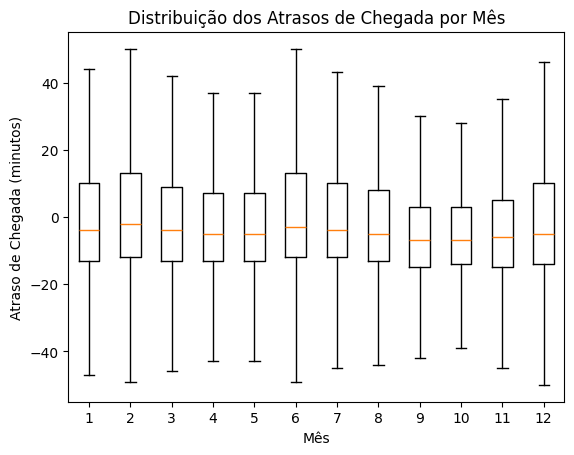

In [33]:
months = sorted(df['MONTH'].unique())
data_by_month = [
    df[df['MONTH'] == m]['ARRIVAL_DELAY'].dropna()
    for m in months
]

plt.figure()
plt.boxplot(data_by_month, labels=months, showfliers=False)
plt.xlabel("Mês")
plt.ylabel("Atraso de Chegada (minutos)")
plt.title("Distribuição dos Atrasos de Chegada por Mês")
plt.show()

#### Medidas de posição

In [34]:
positive_delays = df[df['ARRIVAL_DELAY'] > 0]['ARRIVAL_DELAY']

# Calcular quartis e percentil 90
q1 = positive_delays.quantile(0.25)
q2 = positive_delays.quantile(0.5)
q3 = positive_delays.quantile(0.75)
p90 = positive_delays.quantile(0.9)

print("Medidas de posição dos atrasos na chegada:")
print(f"Q1 (25% dos voos atrasam até): {q1:.2f} minutos")
print(f"Q2 (mediana, 50% dos voos atrasam até): {q2:.2f} minutos")
print(f"Q3 (75% dos voos atrasam até): {q3:.2f} minutos")
print(f"Percentil 90 (90% dos voos têm atraso inferior a): {p90:.2f} minutos")

Medidas de posição dos atrasos na chegada:
Q1 (25% dos voos atrasam até): 6.00 minutos
Q2 (mediana, 50% dos voos atrasam até): 15.00 minutos
Q3 (75% dos voos atrasam até): 39.00 minutos
Percentil 90 (90% dos voos têm atraso inferior a): 87.00 minutos


## Conclusões

Fazer resumo de tudo acima

## Validação e Avaliação dos Modelos


### 🤖 Modelo Supervisionado – Classificação de Atrasos

#### Limpeza e tratamento dos dados
Para melhorar a qualidade da avaliação, voos cancelados ou desviados foram removidos da base de treinamento, uma vez que não representam atrasos operacionais convencionais. Além disso, foi identificado desbalanceamento da variável alvo, sendo adotado o uso de ponderação de classes. Métricas como Recall, F1-score e ROC-AUC foram priorizadas em detrimento da acurácia simples.

In [35]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

df_model_sup = df.copy()

# Tornar ARRIVAL_DELAY numérica
df_model_sup["DELAYED"] = (df_model_sup["ARRIVAL_DELAY"] > 0).astype(int)

# Remover outras colunas desnecessárias
df_model_sup = df_model_sup.drop(columns=['FLIGHT_NUMBER', 'DEPARTURE_TIME', 'TAXI_OUT', 'ELAPSED_TIME', 'TAXI_IN',
    'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'SCHEDULED_ARRIVAL' ])

# Remover voos cancelados e desviados
df_model_sup = df_model_sup[
    (df_model_sup["CANCELLED"] == 0) &
    (df_model_sup["DIVERTED"] == 0)
].copy()

# One-Hot Encoding em dados de aeroportos e companhias aéreas
cat_features = ["AIRLINE", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT"]
num_features = [
    "MONTH", "DAY_OF_WEEK",
    "SCHEDULED_DEPARTURE", "SCHEDULED_TIME", "DISTANCE"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
        ("num", "passthrough", num_features)
    ]
)

# Definir faixa horária
def faixa_horaria(h):
    if h < 600:
        return "madrugada"
    elif h < 1200:
        return "manha"
    elif h < 1800:
        return "tarde"
    else:
        return "noite"

df_model_sup["SCHEDULED_TIME_SLOT"] = df_model_sup["SCHEDULED_DEPARTURE"].apply(faixa_horaria)

# Definir final de semana
df_model_sup["WEEKEND"] = df_model_sup["DAY_OF_WEEK"].isin([6, 7]).astype(int)

df_model_sup.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,SCHEDULED_TIME,DISTANCE,DIVERTED,CANCELLED,DELAYED,SCHEDULED_TIME_SLOT,WEEKEND
0,2015,1,1,4,AS,ANC,SEA,5,-11.0,205.0,1448,0,0,0,madrugada,0
1,2015,1,1,4,AA,LAX,PBI,10,-8.0,280.0,2330,0,0,0,madrugada,0
2,2015,1,1,4,US,SFO,CLT,20,-2.0,286.0,2296,0,0,1,madrugada,0
3,2015,1,1,4,AA,LAX,MIA,20,-5.0,285.0,2342,0,0,0,madrugada,0
4,2015,1,1,4,AS,SEA,ANC,25,-1.0,235.0,1448,0,0,0,madrugada,0


#### Regressão Logística

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

df_train, df_test = train_test_split(
    df_model_sup,
    test_size=0.2,
    random_state=42,
    stratify=df_model_sup["DELAYED"]
)

def target_encoding_fit(df_model_sup, col, target):
    encoding = df_model_sup.groupby(col)[target].mean()
    global_mean = df_model_sup[target].mean()
    return encoding, global_mean


def target_encoding_transform(series, encoding, global_mean):
    return series.map(encoding).fillna(global_mean)

# Ajusta no treino
enc_origin, mean_delay = target_encoding_fit(df_train, "ORIGIN_AIRPORT", "DELAYED")
enc_dest, _ = target_encoding_fit(df_train, "DESTINATION_AIRPORT", "DELAYED")

# Aplica no treino
df_train["ORIGIN_TE"] = target_encoding_transform(
    df_train["ORIGIN_AIRPORT"], enc_origin, mean_delay
)

df_train["DEST_TE"] = target_encoding_transform(
    df_train["DESTINATION_AIRPORT"], enc_dest, mean_delay
)

# Aplica no teste
df_test["ORIGIN_TE"] = target_encoding_transform(
    df_test["ORIGIN_AIRPORT"], enc_origin, mean_delay
)

df_test["DEST_TE"] = target_encoding_transform(
    df_test["DESTINATION_AIRPORT"], enc_dest, mean_delay
)

df_train = pd.get_dummies(
    df_train,
    columns=["AIRLINE", "SCHEDULED_TIME_SLOT"],
    drop_first=True
)

df_test = pd.get_dummies(
    df_test,
    columns=["AIRLINE", "SCHEDULED_TIME_SLOT"],
    drop_first=True
)

# Alinhar colunas (importante!)
df_train, df_test = df_train.align(df_test, join="left", axis=1, fill_value=0)

features = [
    "MONTH",
    "DAY_OF_WEEK",
    "SCHEDULED_DEPARTURE",
    "SCHEDULED_TIME",
    "DISTANCE",
    "WEEKEND",
    "ORIGIN_TE",
    "DEST_TE"
]

# adiciona dummies automaticamente
features += [c for c in df_train.columns if c.startswith("AIRLINE_")]
features += [c for c in df_train.columns if c.startswith("SCHEDULED_TIME_SLOT_")]

X_train = df_train[features]
y_train = df_train["DELAYED"]

X_test = df_test[features]
y_test = df_test["DELAYED"]

model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))


Matriz de Confusão:
[[409626 315797]
 [166348 251031]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.71      0.56      0.63    725423
           1       0.44      0.60      0.51    417379

    accuracy                           0.58   1142802
   macro avg       0.58      0.58      0.57   1142802
weighted avg       0.61      0.58      0.59   1142802



O modelo apresentou recall de 60% para voos atrasados, indicando boa capacidade de identificação de atrasos. Observa-se, entretanto, uma taxa elevada de falsos positivos, refletida em uma precisão de 44%. Tal comportamento é aceitável no contexto do problema, onde a priorização da detecção de atrasos é mais relevante do que a redução de alarmes falsos.

#### Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_leaf=50,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Matriz de Confusão - Random Forest")
print(confusion_matrix(y_test, y_pred_rf))

print("\nRelatório de Classificação - Random Forest")
print(classification_report(y_test, y_pred_rf))



Matriz de Confusão - Random Forest
[[425489 299934]
 [153258 264121]]

Relatório de Classificação - Random Forest
              precision    recall  f1-score   support

           0       0.74      0.59      0.65    725423
           1       0.47      0.63      0.54    417379

    accuracy                           0.60   1142802
   macro avg       0.60      0.61      0.60   1142802
weighted avg       0.64      0.60      0.61   1142802



O modelo Random Forest apresentou desempenho superior à Regressão Logística em todas as métricas avaliadas. Houve aumento do F1-score e do recall da classe de interesse (voos atrasados), indicando melhor capacidade de identificar atrasos, mesmo em um cenário de dados desbalanceados e alta dimensionalidade.

### 🤖 Modelo não supervisionado
Foi aplicada uma abordagem de aprendizado não supervisionado utilizando o algoritmo K-Means para agrupar voos com características semelhantes, considerando horário programado, duração, distância e se o voo ocorre em fim de semana. A análise dos clusters revelou diferenças significativas na taxa de atraso entre os grupos, indicando que determinados perfis de voo apresentam maior propensão a atrasos.

In [39]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df_cluster = df_model_sup.copy()

cluster_features = [
    "SCHEDULED_DEPARTURE",
    "SCHEDULED_TIME",
    "DISTANCE",
    "WEEKEND"
]

X_cluster = df_cluster[cluster_features].copy()

# Garantir que tudo é numérico
X_cluster = X_cluster.apply(pd.to_numeric, errors="coerce")

# Remover linhas com NaN (poucas)
X_cluster.dropna(inplace=True)

scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(
    n_clusters=4,
    random_state=42,
    n_init=10
)

clusters = kmeans.fit_predict(X_cluster_scaled)

df_cluster = df_cluster.loc[X_cluster.index]
df_cluster["CLUSTER"] = clusters

df_cluster["CLUSTER"].value_counts()
df_cluster.groupby("CLUSTER")["DELAYED"].mean()
df_cluster.groupby("CLUSTER")[cluster_features].mean()


,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,WEEKEND
CLUSTER,,,,
0,1738.698979,111.312432,575.600501,0.00000
1,1327.223738,120.188410,648.742698,1.00000
2,1347.147311,283.696481,1983.082771,0.23437
3,909.663703,118.469158,630.851494,0.00000


A análise dos clusters revelou perfis distintos de voo. Observou-se que voos longos, com maior duração e distância (Cluster 2), apresentam maior propensão a atrasos, enquanto voos curtos realizados no início do dia (Cluster 3) tendem a ser mais pontuais. Esses padrões foram identificados sem o uso de rótulos, demonstrando a capacidade da abordagem não supervisionada de revelar estruturas latentes nos dados.

Para facilitar a visualização dos clusters, foi aplicada a técnica de PCA para redução de dimensionalidade, projetando os dados em duas dimensões. Devido ao grande volume de registros, utilizou-se uma amostragem aleatória para fins de visualização, mantendo o modelo treinado sobre o conjunto completo de dados.

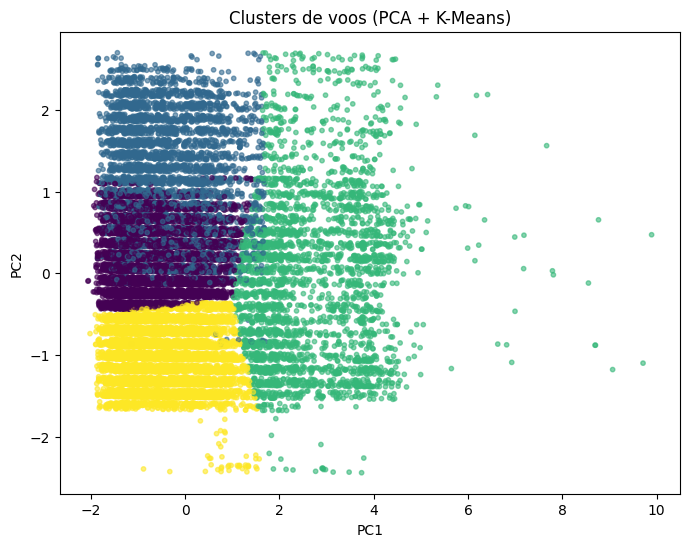

In [43]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_cluster_scaled)

df_plot = df_cluster.copy()
df_plot["PC1"] = X_pca[:, 0]
df_plot["PC2"] = X_pca[:, 1]

df_plot_sample = df_plot.sample(20_000, random_state=42)

plt.figure(figsize=(8, 6))

plt.scatter(
    df_plot_sample["PC1"],
    df_plot_sample["PC2"],
    c=df_plot_sample["CLUSTER"],
    s=10,
    alpha=0.6
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters de voos (PCA + K-Means)")
plt.show()



🟢 Cluster verde (direita)

👉 Voos longos

Alta distância

Maior duração

Maior dispersão

📌 Normal ter mais variabilidade → mais fatores de atraso

🔵 Cluster azul (esquerda superior)

👉 Voos curtos, horários mais tardios

Fim de tarde / noite

Dias úteis

📌 Sujeitos a atrasos acumulados do dia

🟣 Cluster roxo (centro esquerdo)

👉 Voos curtos, horários intermediários

Meio do dia

Perfil operacional mais estável

🟡 Cluster amarelo (inferior esquerdo)

👉 Voos curtos, manhã cedo

Cadeia operacional “limpa”

Normalmente mais pontuais